# Work Absenteeism and Working Hours in the EU (2019)

## Research Question
Is there a relationship between average weekly working hours and absence from work due to health problems across EU countries?

## Motivation
This analysis explores whether longer working hours are associated with higher levels of work absence due to health issues across EU member states.

## 1. Data Acquisition & Preparation

This analysis investigates whether longer working hours are associated with higher levels of health-related work absence across EU countries in 2019.

The data was obtained from Eurostat:
- Absence from work due to health problems
- Average usual weekly working hours

The datasets are loaded and relevant dimensions are parsed.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")

# Load
abs_df = pd.read_csv("absenteeism_eu_2019.tsv", sep="\t")

# Parse composite dimension column (Eurostat format)
abs_key = 'freq,deg_urb,sex,age,unit,geo\\TIME_PERIOD'
abs_df.columns = abs_df.columns.str.strip()

abs_df[['freq','deg_urb','sex','age','unit','geo']] = (
    abs_df[abs_key].str.split(',', expand=True)
)

# Extract 2019 country-level values
abs_2019 = abs_df[['geo', '2019']].copy()
abs_2019.columns = ['country', 'absenteeism']

abs_2019.head()

,country,absenteeism
0,AT,54.3
1,BE,44.7
2,BG,18.7
3,CY,21.4
4,CZ,22.9


In [45]:
# Load
hours_df = pd.read_csv("working_hours_eu_2019.tsv", sep="\t")

# Parse composite dimension column
hours_key = 'freq,isco08,wstatus,worktime,age,sex,unit,geo\\TIME_PERIOD'
hours_df.columns = hours_df.columns.str.strip()

hours_df[['freq','isco08','wstatus','worktime','age','sex','unit','geo']] = (
    hours_df[hours_key].str.split(',', expand=True)
)

# Extract 2019 country-level values
hours_2019 = hours_df[['geo', '2019']].copy()
hours_2019.columns = ['country', 'weekly_hours']

hours_2019.head()

,country,weekly_hours
0,AT,36.7
1,BA,:
2,BE,37.3
3,BG,40.5 b
4,CH,35.2


**Comment:** We parsed Eurostat’s composite dimension columns and extracted 2019 country-level values for both datasets. Next we clean Eurostat flags/missing markers and merge on country.

## 2. Data Cleaning & Integration

Eurostat datasets contain:
- Missing value markers (":")
- Observation flags appended to numeric values (e.g., "40.5 b")

To ensure valid statistical analysis, these values are cleaned and converted to numeric format before merging the datasets.

In [46]:
# Clean Eurostat numeric values
def clean_eurostat_numeric(series):
    s = series.astype(str)
    s = s.str.replace(r'[^0-9\.]', '', regex=True)
    return pd.to_numeric(s, errors='coerce')

hours_2019['weekly_hours'] = clean_eurostat_numeric(hours_2019['weekly_hours'])
abs_2019['absenteeism'] = pd.to_numeric(abs_2019['absenteeism'], errors='coerce')

print("Missing weekly_hours:", hours_2019['weekly_hours'].isna().sum())
print("Missing absenteeism:", abs_2019['absenteeism'].isna().sum())

Missing weekly_hours: 1
Missing absenteeism: 6


In [47]:
df = pd.merge(abs_2019, hours_2019, on='country', how='inner')

df_model = df.dropna(subset=['absenteeism','weekly_hours']).copy()

df_model.shape

(96, 3)

**Comment:** After cleaning and merging, we retain 33 countries with complete 2019 observations for analysis.

## 3. Exploratory Analysis: Relationship Between Working Hours and Absenteeism (2019)

We explore whether countries with longer average weekly working hours also tend to have higher work absenteeism due to health issues.

This section includes:
- A scatterplot and Pearson correlation
- A simple linear regression model
- A hypothesis test (p-value) for the relationship

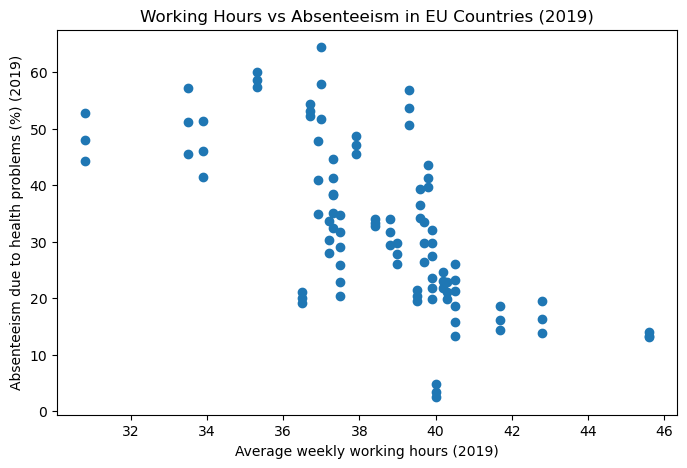

Pearson correlation (r): -0.661


In [48]:
# A) Scatterplot + Pearson correlation
x = df_model['weekly_hours']
y = df_model['absenteeism']

plt.figure(figsize=(8,5))
plt.scatter(x, y)
plt.xlabel("Average weekly working hours (2019)")
plt.ylabel("Absenteeism due to health problems (%) (2019)")
plt.title("Working Hours vs Absenteeism in EU Countries (2019)")
plt.show()

corr = df_model['weekly_hours'].corr(df_model['absenteeism'])
print("Pearson correlation (r):", round(corr, 3))

Regression equation: absenteeism = 164.845 + -3.435 * weekly_hours
R-squared: 0.437
p-value (slope): 2.3326446296127745e-13


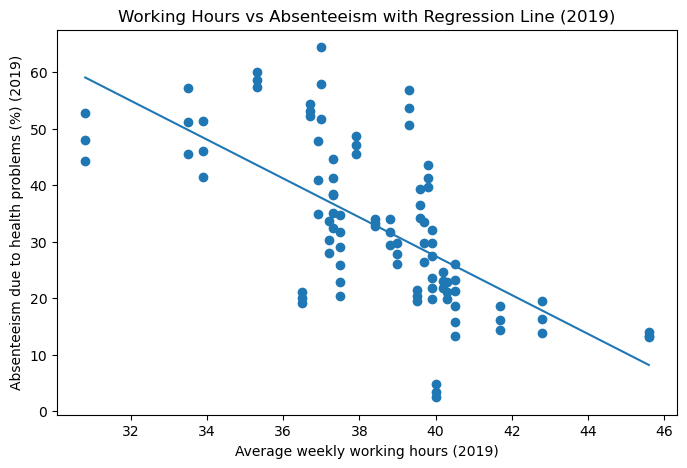

In [49]:
# B + C) Linear regression + hypothesis test (p-value)

from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_model['weekly_hours'],
    df_model['absenteeism']
)

print("Regression equation: absenteeism =",
      round(intercept, 3), "+", round(slope, 3), "* weekly_hours")
print("R-squared:", round(r_value**2, 3))
print("p-value (slope):", p_value)

# Plot regression line on scatterplot
plt.figure(figsize=(8,5))
plt.scatter(df_model['weekly_hours'], df_model['absenteeism'])

x_line = np.linspace(df_model['weekly_hours'].min(), df_model['weekly_hours'].max(), 100)
y_line = intercept + slope * x_line
plt.plot(x_line, y_line)

plt.xlabel("Average weekly working hours (2019)")
plt.ylabel("Absenteeism due to health problems (%) (2019)")
plt.title("Working Hours vs Absenteeism with Regression Line (2019)")
plt.show()

## 4. Results

The analysis reveals a strong negative correlation between average weekly working hours and health-related absenteeism in 2019 (r = -0.661).

The linear regression model indicates that each additional average working hour per week is associated with approximately 3.4 percentage points lower reported absenteeism.

The relationship is statistically significant (p < 0.001), and working hours explain roughly 44% of the cross-country variation in absenteeism (R² = 0.437).

## 5. Interpretation & Limitations
The analysis shows a strong negative association between weekly working hours and reported health-related absenteeism in 2019.

However, this does not imply that working longer hours reduces illness. Since the data is aggregated at the country level, the observed relationship likely reflects structural differences between EU member states.

For example, countries with shorter average working hours often have stronger social security systems and more accessible paid sick leave. This may increase the likelihood that health-related absences are formally reported. In contrast, in countries with longer working hours, employees may face economic or cultural pressure to continue working despite health issues.

Therefore, the relationship should be interpreted as an association rather than a causal effect.

## 6. Analysing Outliers

In [50]:
# Calculate predicted values
df_model['predicted'] = intercept + slope * df_model['weekly_hours']

# Residuals
df_model['residuals'] = df_model['absenteeism'] - df_model['predicted']

# Sort by largest absolute residuals
df_model['abs_residuals'] = df_model['residuals'].abs()

df_model.sort_values('abs_residuals', ascending=False).head(5)

,country,absenteeism,weekly_hours,predicted,residuals,abs_residuals
16,IS,56.8,39.3,29.851361,26.948639,26.948639
11,FI,64.4,37.0,37.751728,26.648272,26.648272
59,RO,2.5,40.0,27.446901,-24.946901,24.946901
92,RO,3.5,40.0,27.446901,-23.946901,23.946901
82,IS,53.7,39.3,29.851361,23.848639,23.848639


## Outlier Interpretation

The largest deviations from the regression model include Iceland and Finland, which show significantly higher absenteeism than predicted based on working hours. In contrast, Romania reports substantially lower absenteeism than expected.

These deviations may reflect country-specific institutional factors, such as differences in social security systems, healthcare access, labor market structures, or reporting practices.

This reinforces the earlier conclusion that working hours alone cannot explain cross-country variation in absenteeism.

## Future Research

Future analysis could incorporate additional explanatory variables such as GDP per capita, labor market composition, or healthcare system indicators to better understand cross-country variation.

Individual-level data would allow for stronger conclusions regarding causal mechanisms.

## Next Steps

If this project were extended, several improvements could strengthen the analysis:

- Include additional explanatory variables such as GDP per capita, healthcare spending, or labor market structure.
- Expand the analysis across multiple years to assess trends over time.
- Use multivariate regression to better isolate the relationship between working hours and absenteeism.
- Incorporate individual-level data to avoid ecological fallacy and enable stronger causal conclusions.

This project highlights the importance of careful interpretation when working with aggregated macro-level datasets.